In [1]:
# imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

#notebook settings
pd.set_option('display.max_columns', None)

from scipy.stats import uniform, randint

# building a pipeline to preprocess the data
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve, validation_curve, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import os

# File Loading

In [2]:
# Paths to feature files
train_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/prepared_claims_data_train_median.csv"
val_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/prepared_claims_data_val_median.csv"
test_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/prepared_claims_data_test_median.csv"

# Paths to target files
ytrain_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/y_train_encoded_median.csv"
yval_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/y_val_encoded_median.csv"
ytest_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/y_test_encoded_median.csv"

# Load the feature datasets
X_train = pd.read_csv(train_path)
X_val = pd.read_csv(val_path)
X_test = pd.read_csv(test_path)

# Load the target datasets
y_train = pd.read_csv(ytrain_path)
y_val = pd.read_csv(yval_path)
y_test = pd.read_csv(ytest_path)

# Inspect loaded data
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)


X_train shape: (346576, 42) y_train shape: (346576, 1)
X_val shape: (91844, 42) y_val shape: (91844, 1)
X_test shape: (114806, 42) y_test shape: (114806, 1)


/var/folders/2m/t2s2zdt15tgd3q3dmyd7y88r0000gn/T/ipykernel_21701/3407831173.py:14: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  X_test = pd.read_csv(test_path)


In [3]:
print(X_train.columns)


Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Carrier Name', 'Carrier Type', 'Claim Identifier', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Description', 'Zip Code', 'Number of Dependents',
       'Cause Injury Category', 'Nature of Injury Category',
       'Body Part Category', 'Age_Group', 'Wage_Group', 'Carrier Name Grouped',
       'Lag_Time', 'Accident_to_C2_Lag', 'Accident Date_Year',
       'Accident Date_Month', 'Assembly Date_Month', 'Assembly Date_Day',
       'C-2 Date_Year', 'C-2 Date_Month', 'C-2 Date_Day', 'Accident_Month_Sin',
       'Accident_Month_Cos', 'Accident_Day', 'Assembly_Year',
       'Assembly_Month_Sin', 'Assembly_Month_Cos', 'Assembly_Day',
       'C-2_Month_Sin', 'C-2_Month_Cos', 'C-2_Day'],
      dtype='object')


In [4]:
y_train.head()

,Claim Injury Type
0,0.0
1,2.0
2,4.0
3,1.0
4,1.0


In [5]:
y_train.head()

,Claim Injury Type
0,0.0
1,2.0
2,4.0
3,1.0
4,1.0


# Encodings of the features

We decide to encode the variables as follows:
- __One-Hot Encoding:__ For variables with a small number of unique values (< 5); preferable because it treats each category independently and avoids introducing an artificial order.
- __Label Encoding:__ For variables with a larger number of categories or variables where there is a clear order or hierarchy.
- __Ordinal Encoding:__ For variables with a natural order or numeric-like scale.

| **Variable**                     | **Encoding Type**       | **Reason**                                                                 |
|----------------------------------|-------------------------|-----------------------------------------------------------------------------|
| Age at Injury                    | None                   | Numerical variable; leave as-is.                                           |
| Attorney/Representative          | One-Hot                | Binary categorical (Yes/No).                                               |
| Average Weekly Wage              | None                   | Numerical variable; leave as-is.                                           |
| Carrier Name                     | Label                  | High-cardinality categorical; use Label Encoding.                          |
| Carrier Type                     | Label                  | Nominal categorical; Label Encoding is efficient for lower cardinality.    |
| Claim Identifier                 | None                   | Unique identifier; leave as-is.                                            |
| Claim Injury Type                | Label                  | Multiclass target; Label Encoding is standard for targets.                 |
| County of Injury                 | Label                  | High-cardinality categorical; Label Encoding is better for efficiency.     |
| COVID-19 Indicator               | One-Hot                | Binary categorical (Yes/No).                                               |
| District Name                    | Label                  | Categorical variable, moderate cardinality; Label Encoding is efficient.   |
| Gender                           | One-Hot                | Binary categorical (Male/Female/Other).                                    |
| Industry Code Description        | Label                  | High-cardinality nominal; Label Encoding is preferred.                     |
| Medical Fee Region               | One-Hot                | Nominal categorical (regions); One-Hot avoids unintended ordinal meaning.  |
| WCIO Cause of Injury Code        | Label                  | Numerical but nominal; Label Encoding fits better for this use case.       |
| WCIO Nature of Injury Code       | Label                  | Numerical but nominal; Label Encoding works best.                          |
| WCIO Part Of Body Code           | Label                  | Numerical but nominal; Label Encoding works best.                          |
| Zip Code                         | Label                  | High-cardinality categorical; Label Encoding is efficient.                 |
| Number of Dependents             | None                   | Numerical variable; leave as-is.                                           |
| Lag_Time                         | None                   | Numerical variable; leave as-is.                                           |
| Accident_to_C2_Lag               | None                   | Numerical variable; leave as-is.                                           |
| Accident Date_Year               | None                   | Numerical variable; leave as-is.                                           |
| Accident Date_Month              | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| Accident Date_Day                | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Assembly Date_Year               | None                   | Numerical variable; leave as-is.                                           |
| Assembly Date_Month              | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| Assembly Date_Day                | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| C-2 Date_Year                    | None                   | Numerical variable; leave as-is.                                           |
| C-2 Date_Month                   | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| C-2 Date_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Accident_Year                    | None                   | Numerical variable; leave as-is.                                           |
| Accident_Month                   | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| Accident_Month_Sin               | None                   | Already processed as cyclical; leave as-is.                                |
| Accident_Month_Cos               | None                   | Already processed as cyclical; leave as-is.                                |
| Accident_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Assembly_Year                    | None                   | Numerical variable; leave as-is.                                           |
| Assembly_Month                   | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| Assembly_Month_Sin               | None                   | Already processed as cyclical; leave as-is.                                |
| Assembly_Month_Cos               | None                   | Already processed as cyclical; leave as-is.                                |
| Assembly_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| C-2_Year                         | None                   | Numerical variable; leave as-is.                                           |
| C-2_Month                        | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| C-2_Month_Sin                    | None                   | Already processed as cyclical; leave as-is.                                |
| C-2_Month_Cos                    | None                   | Already processed as cyclical; leave as-is.                                |
| C-2_Day                          | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Cause Injury Category            | Label                  | Nominal categorical; Label Encoding is efficient.                          |
| Nature of Injury Category        | Label                  | Nominal categorical; Label Encoding is efficient.                          |
| Body Part Category               | Label                  | Nominal categorical; Label Encoding is efficient.                          |
| Age_Group                        | Ordinal                | Categorical with inherent order (e.g., Teen, Adult); Ordinal Encoding fits.|
| Wage_Group                       | Ordinal                | Categorical with inherent order (e.g., Low, Medium, High); Ordinal fits.   |
| Carrier Name Grouped             | Label                  | High-cardinality nominal; Label Encoding is efficient.                     |
| Claim Type Numeric               | None                   | Already encoded as numeric; leave as-is.                                   |


In [6]:
X_train['Region'] = X_train['Zip Code'].astype(str).str[0]
X_val['Region'] = X_val['Zip Code'].astype(str).str[0]
X_test['Region'] = X_test['Zip Code'].astype(str).str[0]


In [7]:
X_train['State'] = X_train['Zip Code'].astype(str).str[:2]
X_val['State'] = X_val['Zip Code'].astype(str).str[:2]
X_test['State'] = X_test['Zip Code'].astype(str).str[:2]


In [8]:
X_train = X_train.drop(columns=[ 'Carrier Name', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code'])
X_val = X_val.drop(columns=[ 'Carrier Name', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code'])
X_test = X_test.drop(columns=['Carrier Name', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code'])

## Numerical Features

In [9]:
numerical_features = [
    'Age at Injury', 'Average Weekly Wage', 'Claim Identifier',
    'Number of Dependents', 'Lag_Time', 'Accident_to_C2_Lag',
    'Accident Date_Year', 'Accident Date_Month', 'Accident_Day',
    'Assembly Date_Month', 'Assembly Date_Day',
    'C-2 Date_Year', 'C-2 Date_Month', 'C-2 Date_Day',
    'Accident_Month_Sin', 'Accident_Month_Cos',
    'Assembly_Year', 'Assembly_Month_Sin', 'Assembly_Month_Cos',
    'Assembly_Day', 'C-2_Month_Sin', 'C-2_Month_Cos', 'C-2_Day'
]

## One Hot Encoding

In [10]:
onehot_features = [
    'Attorney/Representative', 'COVID-19 Indicator', 'Gender', 
    'Carrier Type', 'District Name', 'Industry Code Description', 
    'County of Injury', 'Cause Injury Category', 'Nature of Injury Category', 
    'Body Part Category', 'Carrier Name Grouped', 'Region', 'State'

]

In [11]:
# Initialize OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

## Ordinal Encoding 

In [12]:
# Define ordinal features and categories
ordinal_features = ['Age_Group', 'Wage_Group', 'Medical Fee Region']  # Add ordinal features if applicable
ordinal_categories = [
    ['Teen', 'Young Adult', 'Adult', 'Middle-Aged Adult', 'Older Adult', 'Senior'],  # Age_Group
    ['Low', 'Below Average', 'Average', 'Above Average', 'High'],  # Wage_Group
    ['I','II', 'III', 'IV', 'UK'] # Medical Fee Region
]

# Initialize and fit OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)




# Encoding and Scaling Pipeline

In [ ]:
# Define transformations
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('scaler', StandardScaler())  # Optional scaling for one-hot encoded features
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())  # Scale the ordinal features
])



numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale numerical features
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('onehot', onehot_transformer, onehot_features),
    ('ordinal', ordinal_transformer, ordinal_features),
    ('num', numerical_transformer, numerical_features)  # Ensure numerical features are also scaled
])

# Apply the preprocessor: fit on training data and transform all datasets
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# Retrieve column names dynamically
onehot_names = preprocessor.named_transformers_['onehot']['onehot'].get_feature_names_out(onehot_features)
ordinal_names = ordinal_features  # Ordinal features retain their original names
numerical_names = numerical_features

# Combine all transformed column names
feature_names = np.concatenate([onehot_names, ordinal_names, numerical_names])

# Convert transformed datasets back to DataFrames with column names
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names, index=X_train.index)
X_val_transformed = pd.DataFrame(X_val_transformed, columns=feature_names, index=X_val.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names, index=X_test.index)

# Save the preprocessor for future use
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Outputs
print("Validated feature groups:")
print("One-hot features:", onehot_features)
print("Label features:", label_features)
print("Numerical features:", numerical_features)
print("Ordinal features:", ordinal_features)

print("Transformed feature names:")
print(feature_names)

### Scalling test 2

import pandas as pd
import numpy as np
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Define transformations
# 1. One-Hot Encoding: No scaling for binary variables
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Remove scaling for binary vars
])

# 2. Ordinal Encoding: Ordinal categories, followed by scaling
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())  # Scale the ordinal features
])



# 4. Numerical Features: Apply only scaling
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale numerical features
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('onehot', onehot_transformer, onehot_features),  # No scaling for one-hot encoded vars
    ('ordinal', ordinal_transformer, ordinal_features),
    ('num', numerical_transformer, numerical_features)
])

# Apply the preprocessor: fit on training data and transform all datasets
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# Retrieve column names dynamically
onehot_names = preprocessor.named_transformers_['onehot']['onehot'].get_feature_names_out(onehot_features)
ordinal_names = ordinal_features  # Ordinal features retain their original names
numerical_names = numerical_features

# Combine all transformed column names into a single list
feature_names = np.concatenate([onehot_names, ordinal_names, numerical_names])

# Convert transformed datasets back to DataFrames with proper column names and indices
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names, index=X_train.index)
X_val_transformed = pd.DataFrame(X_val_transformed, columns=feature_names, index=X_val.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names, index=X_test.index)

# Save the preprocessor for future use
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Outputs for validation
print("\nFeature Groups:")
print("One-hot features:", onehot_features)
print("Numerical features:", numerical_features)
print("Ordinal features:", ordinal_features)

print("\nTransformed feature names:")
print(feature_names)

# Verify the first rows of the transformed data
print("\nX_train_transformed:")
print(X_train_transformed.head())

print("\nX_val_transformed:")
print(X_val_transformed.head())

print("\nX_test_transformed:")
print(X_test_transformed.head())

In [16]:
X_train_transformed.head()

,Attorney/Representative_N,Attorney/Representative_Y,COVID-19 Indicator_N,COVID-19 Indicator_Y,Gender_F,Gender_M,Gender_Other,Carrier Type_1A. PRIVATE,Carrier Type_2A. SIF,Carrier Type_3A. SELF PUBLIC,Carrier Type_4A. SELF PRIVATE,Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS,Carrier Type_5D. SPECIAL FUND - UNKNOWN,Carrier Type_UNKNOWN,District Name_ALBANY,District Name_BINGHAMTON,District Name_BUFFALO,District Name_HAUPPAUGE,District Name_NYC,District Name_ROCHESTER,District Name_STATEWIDE,District Name_SYRACUSE,Industry Code Description_ACCOMMODATION AND FOOD SERVICES,Industry Code Description_ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT,"Industry Code Description_AGRICULTURE, FORESTRY, FISHING AND HUNTING","Industry Code Description_ARTS, ENTERTAINMENT, AND RECREATION",Industry Code Description_CONSTRUCTION,Industry Code Description_EDUCATIONAL SERVICES,Industry Code Description_FINANCE AND INSURANCE,Industry Code Description_HEALTH CARE AND SOCIAL ASSISTANCE,Industry Code Description_INFORMATION,Industry Code Description_MANAGEMENT OF COMPANIES AND ENTERPRISES,Industry Code Description_MANUFACTURING,Industry Code Description_MINING,Industry Code Description_OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION),"Industry Code Description_PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES",Industry Code Description_PUBLIC ADMINISTRATION,Industry Code Description_REAL ESTATE AND RENTAL AND LEASING,Industry Code Description_RETAIL TRADE,Industry Code Description_TRANSPORTATION AND WAREHOUSING,Industry Code Description_UTILITIES,Industry Code Description_WHOLESALE TRADE,County of Injury_ALBANY,County of Injury_ALLEGANY,County of Injury_BRONX,County of Injury_BROOME,County of Injury_CATTARAUGUS,County of Injury_CAYUGA,County of Injury_CHAUTAUQUA,County of Injury_CHEMUNG,County of Injury_CHENANGO,County of Injury_CLINTON,County of Injury_COLUMBIA,County of Injury_CORTLAND,County of Injury_DELAWARE,County of Injury_DUTCHESS,County of Injury_ERIE,County of Injury_ESSEX,County of Injury_FRANKLIN,County of Injury_FULTON,County of Injury_GENESEE,County of Injury_GREENE,County of Injury_HAMILTON,County of Injury_HERKIMER,County of Injury_JEFFERSON,County of Injury_KINGS,County of Injury_LEWIS,County of Injury_LIVINGSTON,County of Injury_MADISON,County of Injury_MONROE,County of Injury_MONTGOMERY,County of Injury_NASSAU,County of Injury_NEW YORK,County of Injury_NIAGARA,County of Injury_ONEIDA,County of Injury_ONONDAGA,County of Injury_ONTARIO,County of Injury_ORANGE,County of Injury_ORLEANS,County of Injury_OSWEGO,County of Injury_OTSEGO,County of Injury_PUTNAM,County of Injury_QUEENS,County of Injury_RENSSELAER,County of Injury_RICHMOND,County of Injury_ROCKLAND,County of Injury_SARATOGA,County of Injury_SCHENECTADY,County of Injury_SCHOHARIE,County of Injury_SCHUYLER,County of Injury_SENECA,County of Injury_ST. LAWRENCE,County of Injury_STEUBEN,County of Injury_SUFFOLK,County of Injury_SULLIVAN,County of Injury_TIOGA,County of Injury_TOMPKINS,County of Injury_ULSTER,County of Injury_UNKNOWN,County of Injury_WARREN,County of Injury_WASHINGTON,County of Injury_WAYNE,County of Injury_WESTCHESTER,County of Injury_WYOMING,County of Injury_YATES,Cause Injury Category_Collisions and Motor Vehicle Accidents,Cause Injury Category_Explosions and Fire,Cause Injury Category_Exposure to Substances and Environment,Cause Injury Category_Falls and Slips,Cause Injury Category_Lifting and Strain,Cause Injury Category_Natural Disasters and Uncommon Events,Cause Injury Category_Other,Cause Injury Category_Struck By Object or Person,"Cause Injury Category_Tools, Machinery, and Objects",Nature of Injury Category_Burns and Temperature-Related Injuries,Nature of Injury Category_Circulatory and Heart-Related Issues,Nature of Injury Category_Cumulative or Repetitive Injuries,Nature of Injury Category_Infections and Diseases,Nature of Injury Category_Miscellaneous Conditions,Nature of Injury Category_Other,Nature of Injury Category_Physical Tra

## Verificaton of the scalling of the data

In [17]:
# Verify scaled data
print("Scaled X_train mean:",X_train_transformed.mean(axis=0))
print("Scaled X_train std:", X_train_transformed.std(axis=0))

Scaled X_train mean: Attorney/Representative_N    7.038831e-01
Attorney/Representative_Y    2.961169e-01
COVID-19 Indicator_N         9.530146e-01
COVID-19 Indicator_Y         4.698537e-02
Gender_F                     4.150951e-01
                                 ...     
Assembly_Month_Cos          -4.413855e-16
Assembly_Day                -5.790147e-16
C-2_Month_Sin               -1.269570e-15
C-2_Month_Cos                3.879483e-16
C-2_Day                      1.757723e-15
Length: 358, dtype: float64
Scaled X_train std: Attorney/Representative_N    0.456544
Attorney/Representative_Y    0.456544
COVID-19 Indicator_N         0.211608
COVID-19 Indicator_Y         0.211608
Gender_F                     0.492739
                               ...   
Assembly_Month_Cos           1.000001
Assembly_Day                 1.000001
C-2_Month_Sin                1.000001
C-2_Month_Cos                1.000001
C-2_Day                      1.000001
Length: 358, dtype: float64


In [18]:
#Checking the number of features after Scalling
num_features2 = X_train_transformed.shape[1]
print(f"Number of features after encoding: {num_features2}")

Number of features after encoding: 358


## Verificaton of the mapping of the target variable

In [19]:
# Ensure `y_train`, `y_val`, and `y_test` are Series
if isinstance(y_train, pd.DataFrame):
    if 'Claim Injury Type' in y_train.columns:  # Replace with actual column name
        y_train = y_train['Claim Injury Type']
        y_val = y_val['Claim Injury Type']
        y_test = y_test['Claim Injury Type']
    else:
        # If no explicit column name, take the first column
        y_train = y_train.iloc[:, 0]
        y_val = y_val.iloc[:, 0]
        y_test = y_test.iloc[:, 0]

# Verify they are Series
print("y_train type (after extraction):", type(y_train))
print("y_val type (after extraction):", type(y_val))
print("y_test type (after extraction):", type(y_test))


# Verify the mapping
print("Mapped y_train unique values:", y_train.unique())
print("Mapped y_val unique values:", y_val.unique())
print("Mapped y_test unique values:", y_test.unique())

y_train type (after extraction): <class 'pandas.core.series.Series'>
y_val type (after extraction): <class 'pandas.core.series.Series'>
y_test type (after extraction): <class 'pandas.core.series.Series'>
Mapped y_train unique values: [0. 2. 4. 1. 3. 5. 7. 6.]
Mapped y_val unique values: [1. 3. 4. 2. 0. 5. 6. 7.]
Mapped y_test unique values: [4. 3. 2. 1. 0. 5. 7. 6.]


# Feature Selection Pipeline

## Correlation Analysis

In [20]:
correlation_matrix= X_train_transformed.corr(method='spearman')
print(correlation_matrix)

                           Attorney/Representative_N  \
Attorney/Representative_N                   1.000000   
Attorney/Representative_Y                  -1.000000   
COVID-19 Indicator_N                       -0.039035   
COVID-19 Indicator_Y                        0.039035   
Gender_F                                    0.078112   
...                                              ...   
Assembly_Month_Cos                          0.010234   
Assembly_Day                               -0.006058   
C-2_Month_Sin                              -0.005786   
C-2_Month_Cos                               0.008670   
C-2_Day                                    -0.016794   

                           Attorney/Representative_Y  COVID-19 Indicator_N  \
Attorney/Representative_N                  -1.000000             -0.039035   
Attorney/Representative_Y                   1.000000              0.039035   
COVID-19 Indicator_N                        0.039035              1.000000   
COVID-19 Indica

In [38]:
# heatmap 
def cor_heatmap(data):
    cor_matrix = data.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(data=cor_matrix, annot=True, cmap= 'YlGnBu' , fmt='.1')
    plt.title("Correlation Heatmap")
    plt.show()

cor_heatmap(X_train_transformed)

KeyboardInterrupt: 

## Identification of High Correlated Features and Selection of Final Features Using Random Forest 

In [31]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Step 1: Identify Highly Correlated Pairs
high_corr_pairs = []
to_exclude = set()

for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if col != row and abs(correlation_matrix.loc[row, col]) > 0.8:
            high_corr_pairs.append((row, col))
            # Drop the second feature in the pair (arbitrarily)
            if col not in to_exclude:
                to_exclude.add(row)

# Step 2: Exclude Redundant Features
remaining_features = [f for f in X_train_transformed.columns if f not in to_exclude]

# Step 3: Train Random Forest on Remaining Features
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_transformed[remaining_features], y_train)

# Step 4: Feature Importance
feature_importances = pd.Series(rf.feature_importances_, index=remaining_features)
top_features = feature_importances.nlargest(20).index.tolist()

# Step 5: Final Features
final_features = top_features

# Step 6: Output Results
print("\n--- Final Feature Selection ---")
print("\nHigh Correlation Pairs:")
for pair in high_corr_pairs:
    print(f" - {pair[0]} <--> {pair[1]}")

print("\nFeatures to Exclude (High Correlation):")
print(to_exclude)

print("\nRemaining Features After Correlation Filtering:")
print(remaining_features)

print("\nTop 20 Features (Random Forest):")
print(top_features)

print("\nFinal Selected Features:")
for i, feature in enumerate(final_features, 1):
    print(f"{i}. {feature}")


--- Final Feature Selection ---

High Correlation Pairs:
 - Attorney/Representative_Y <--> Attorney/Representative_N
 - Attorney/Representative_N <--> Attorney/Representative_Y
 - COVID-19 Indicator_Y <--> COVID-19 Indicator_N
 - Cause Injury Category_Natural Disasters and Uncommon Events <--> COVID-19 Indicator_N
 - Nature of Injury Category_Infections and Diseases <--> COVID-19 Indicator_N
 - COVID-19 Indicator_N <--> COVID-19 Indicator_Y
 - Cause Injury Category_Natural Disasters and Uncommon Events <--> COVID-19 Indicator_Y
 - Nature of Injury Category_Infections and Diseases <--> COVID-19 Indicator_Y
 - Gender_M <--> Gender_F
 - Gender_F <--> Gender_M
 - Carrier Name Grouped_STATE INSURANCE FUND <--> Carrier Type_2A. SIF
 - State_12 <--> District Name_ALBANY
 - County of Injury_ERIE <--> District Name_BUFFALO
 - County of Injury_SUFFOLK <--> District Name_HAUPPAUGE
 - State_13 <--> District Name_SYRACUSE
 - District Name_BUFFALO <--> County of Injury_ERIE
 - District Name_HAUPPAU

## Lasso Regression

In [32]:
# Step 1: Filter Features in the Dataset
X_train_lasso = X_train_transformed[final_features]
X_val_lasso = X_val_transformed[final_features]
X_test_lasso = X_test_transformed[final_features]

# Train LassoCV
lasso = LassoCV(max_iter=5000, cv=5, random_state=42, alphas=np.logspace(-4, 1, 50))
lasso.fit(X_train_lasso, y_train)


# Initialize and fit LassoCV
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train_lasso, y_train)

# Predict on validation set
y_pred = lasso.predict(X_val_lasso)

# Evaluate
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Print results
print(f"Optimal alpha: {lasso.alpha_}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Optimal alpha: 0.000875862816291694
Mean Squared Error: 0.4139
R^2 Score: 0.6738


In [ ]:
Ridge Regression

In [33]:
from sklearn.linear_model import RidgeCV

X_train_ridge = X_train_transformed[final_features]
X_val_ridge = X_val_transformed[final_features]
X_test_ridge = X_test_transformed[final_features]

ridge = RidgeCV(alphas=np.logspace(-4, 2, 50), cv=5)
ridge.fit(X_train_ridge, y_train)
y_pred_ridge = ridge.predict(X_val_ridge)

mse_ridge = mean_squared_error(y_val, y_pred_ridge)
r2_ridge = r2_score(y_val, y_pred_ridge)

print(f"Optimal alpha (Ridge): {ridge.alpha_}")
print(f"Ridge Mean Squared Error: {mse_ridge:.4f}")
print(f"Ridge R^2 Score: {r2_ridge:.4f}")

Optimal alpha (Ridge): 24.420530945486497
Ridge Mean Squared Error: 0.4137
Ridge R^2 Score: 0.6740


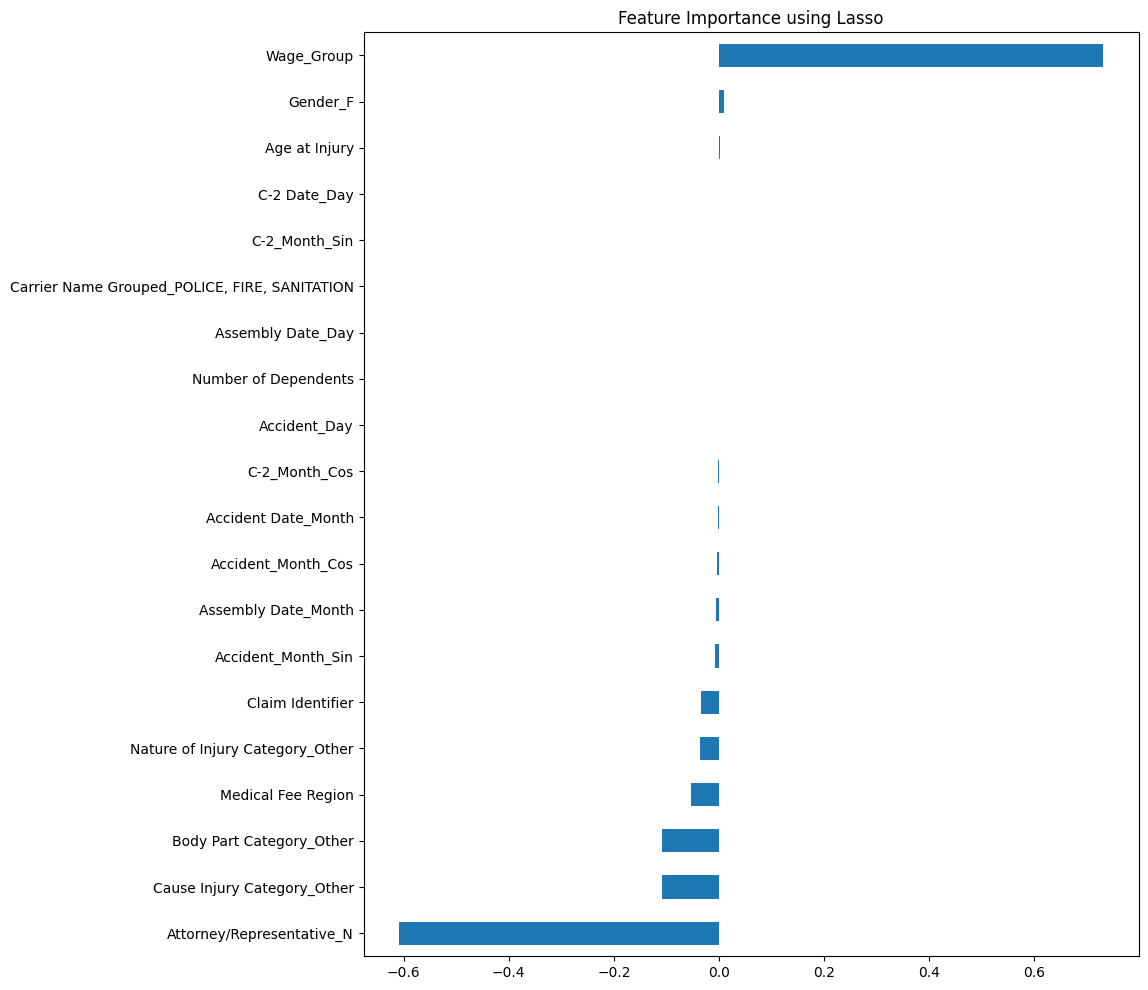

In [34]:
coef = pd.Series(lasso.coef_, index=X_train_lasso.columns)

# Sort coefficients by importance
coef_sorted = coef.sort_values()

# Plot feature importance
def plot_importance(coef, model_name):
    plt.figure(figsize=(10, 12))
    coef.plot(kind="barh")
    plt.title(f"Feature Importance using {model_name}")
    plt.show()

plot_importance(coef_sorted, "Lasso")

In [35]:
# Step 4: Analyze Feature Importance
coef = pd.Series(lasso.coef_, index=final_features)
important_features = coef[coef != 0].index.tolist()
not_important_features = coef[coef == 0].index.tolist()
print("Features with non-zero coefficients:", important_features)
print("/Features with zero coefficients:", not_important_features)



Features with non-zero coefficients: ['Wage_Group', 'Attorney/Representative_N', 'Claim Identifier', 'Age at Injury', 'Accident_Day', 'C-2 Date_Day', 'Body Part Category_Other', 'C-2_Month_Cos', 'Accident Date_Month', 'Accident_Month_Sin', 'Accident_Month_Cos', 'Assembly Date_Month', 'Cause Injury Category_Other', 'Nature of Injury Category_Other', 'Medical Fee Region', 'Gender_F']
/Features with zero coefficients: ['Number of Dependents', 'Assembly Date_Day', 'C-2_Month_Sin', 'Carrier Name Grouped_POLICE, FIRE, SANITATION']


In [36]:
# Ensure both lists exist
final_features = set(final_features)  # Convert to a set for efficient operations
not_important_features = set(not_important_features)

# Remove features from final_features that match those in not_important_features
filtered_features = list(final_features - not_important_features)

# Optional: Sort the resulting list for better readability
filtered_features.sort()

# Output the results
print("Number of features before filtering:", len(final_features))
print("Number of features removed:", len(not_important_features & final_features))
print("Number of features after filtering:", len(filtered_features))

# Save the filtered list back to final_features
final_features2 = filtered_features

# Step 1: Filter Features in the Dataset
X_train_lasso2 = X_train_transformed [final_features2]
X_val_lasso2 = X_val_transformed[final_features2]
X_test_lasso2 = X_test_transformed[final_features2]

# Train LassoCV
lasso = LassoCV(max_iter=5000, cv=5, random_state=42, alphas=np.logspace(-4, 1, 50))
lasso.fit(X_train_lasso2, y_train)
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Initialize and fit LassoCV
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train_lasso2, y_train)

# Predict on validation set
y_pred = lasso.predict(X_val_lasso2)

# Evaluate
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Print results
print(f"Optimal alpha: {lasso.alpha_}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")


Number of features before filtering: 20
Number of features removed: 4
Number of features after filtering: 16
Optimal alpha: 0.000875862816291694
Mean Squared Error: 0.4139
R^2 Score: 0.6738


Optimal number of features: 16
Selected features: ['Accident Date_Month', 'Accident_Day', 'Accident_Month_Cos', 'Accident_Month_Sin', 'Age at Injury', 'Assembly Date_Month', 'Attorney/Representative_N', 'Body Part Category_Other', 'C-2 Date_Day', 'C-2_Month_Cos', 'Cause Injury Category_Other', 'Claim Identifier', 'Gender_F', 'Medical Fee Region', 'Nature of Injury Category_Other', 'Wage_Group']


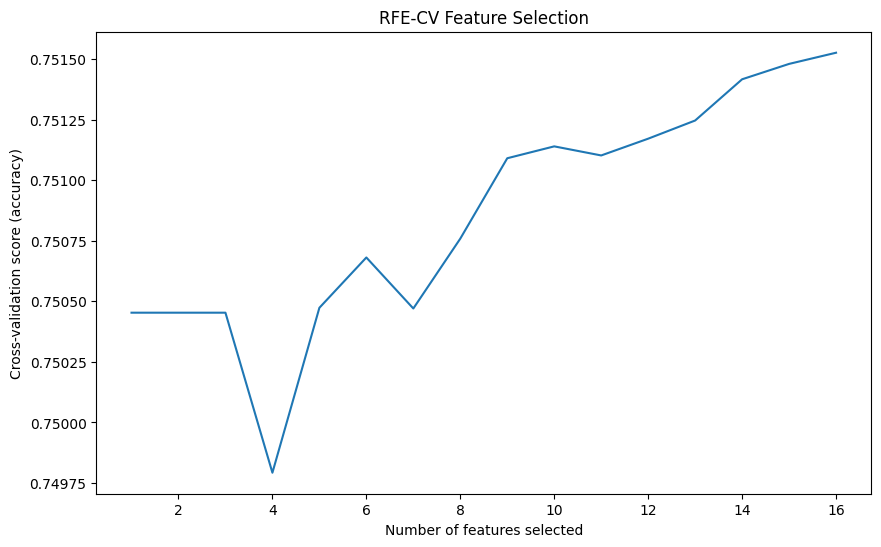

In [37]:
# Define the estimator (e.g., Logistic Regression)
estimator = LogisticRegression(max_iter=1000, random_state=42)

# Configure RFECV with Cross-Validation
rfe_cv = RFECV(
    estimator=estimator,
    step=1,  # Remove one feature at a time
    cv=StratifiedKFold(5),  # 5-Fold Cross-Validation
    scoring="accuracy"  # Metric to optimize (can be adjusted)
)

# Fit RFECV on the training data
rfe_cv.fit(X_train_lasso2, y_train)

# Number of optimal features
print(f"Optimal number of features: {rfe_cv.n_features_}")

# Features selected
selected_features = X_train_lasso2.columns[rfe_cv.support_]
print("Selected features:", selected_features.tolist())

# Plot the cross-validation scores
# Plot the RFE-CV results using cv_results_
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(rfe_cv.cv_results_['mean_test_score']) + 1), rfe_cv.cv_results_['mean_test_score'])
plt.title("RFE-CV Feature Selection")
plt.show()

In [ ]:
import os
import pandas as pd
# Define the absolute path for saving files
processed_dir = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/"

# Ensure the directory exists
os.makedirs(processed_dir, exist_ok=True)

# Define file paths
train_file_path = os.path.join(processed_dir, 'X_train_featured.csv')
val_file_path = os.path.join(processed_dir, 'X_val_featured.csv')
test_file_path = os.path.join(processed_dir, 'X_test_featured.csv')

# Save the filtered datasets with the final features
X_train_lasso2.to_csv(train_file_path, index=True)  # Preserve original indices
X_val_lasso2.to_csv(val_file_path, index=True)     # Preserve original indices
X_test_lasso2.to_csv(test_file_path, index=True)   # Preserve original indices

# Print confirmation messages
print(f"Filtered training data saved to: {train_file_path}")
print(f"Filtered validation data saved to: {val_file_path}")
print(f"Filtered test data saved to: {test_file_path}")